In [124]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
import torch.nn as nn
# Define the FastF1Dataset class
class FastF1Dataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx + self.sequence_length], dtype=torch.float32)

# Load your saved model
def load_model(model_path, model_class, sequence_length, input_dim, device):
    model = model_class(sequence_length, input_dim)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# # # Calculate reconstruction error
# def compute_reconstruction_error(inputs, outputs):
#     return torch.mean((inputs - outputs) ** 2, dim=1).detach().numpy()

def compute_reconstruction_error(inputs, outputs):
    return torch.mean((inputs - outputs) ** 2, dim=(1, 2)).detach().numpy()


# Define your autoencoder class
class LSTMAutoencoder(nn.Module):
    def __init__(self, sequence_length, num_features):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(num_features, 64, batch_first=True)
        self.latent = nn.LSTM(64, 32, batch_first=True)
        self.decoder = nn.LSTM(32, 64, batch_first=True)
        self.output_layer = nn.Linear(64, num_features)

    def forward(self, x):
        x, _ = self.encoder(x)
        x, _ = self.latent(x[:, -1].unsqueeze(1).repeat(1, x.size(1), 1))
        x, _ = self.decoder(x)
        x = self.output_layer(x)
        return x

# Set paths and parameters
# model_path = "AD_19-23_autoencoder_AdamW_lr0001_loss0.4037_fold5.pth"
model_path = "AD_19-23_autoencoder_AdamW_lr0001_ep15_loss0.5003.pth"
new_data_path = "2024_HungarianGrandPrix_MinMaxScaler_normalized_10_SuspensionandDrive.npz"
sequence_length = 20
threshold = 500

# Load the new data
new_data = np.load(new_data_path, allow_pickle=True)['data']
new_data = new_data[:, :-1]  #
new_data_array = np.array(new_data, dtype=np.float32)

# Create the test dataset and data loader
test_dataset = FastF1Dataset(new_data_array, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = new_data_array.shape[1]  # Number of features per timestep
autoencoder = load_model(model_path, LSTMAutoencoder, sequence_length, input_dim, device).to(device)

# Test the model
def test_autoencoder(autoencoder, data_loader, device):
    autoencoder.eval()
    errors = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch.to(device)
            outputs = autoencoder(inputs)
            batch_errors = compute_reconstruction_error(inputs, outputs)
            errors.extend(batch_errors)

    return np.array(errors)

 # Scalar per sequence

reconstruction_errors = test_autoencoder(autoencoder, test_loader, device)

# Set a threshold for anomalies


In [125]:
#new_data (npz) to pandas
import pandas as pd
race_df = pd.DataFrame(new_data)

cols = [
       'Time_in_ms',
       'LapTime_in_ms',
       'LapNumber',
       'Position',
       'Speed',
       'AirTemp',
       'Humidity',
       'Pressure',
       'TrackTemp',
       'WindDirection',
       'WindSpeed',
       'DistanceToDriverAhead',
       'RPM',
       'nGear',
       'Throttle',
       'X', 
       'Y', 
       'Z', 
       'Distance', 
       'TyreLife',
       'Compound',
       'Team',
       'TrackStatus',
       'Rainfall',
       'DriverAhead',
       'Brake',
       'DRS',
       'Event'
    ]

race_df.columns = cols
#first 50 rows of tyrelife
race_df

,Time_in_ms,LapTime_in_ms,LapNumber,Position,Speed,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,...,Distance,TyreLife,Compound,Team,TrackStatus,Rainfall,DriverAhead,Brake,DRS,Event
0,0.000000,0.004581,0.0,1.0,0.000000,0.428571,0.000000,1.0,0.718310,0.00000,...,0.000021,0.000000,3.0,4.0,1.0,0.0,2.0,1.0,0.0,23.0
1,0.000062,0.006315,0.0,1.0,0.000000,0.428571,0.000000,1.0,0.718310,0.00000,...,0.000021,0.000000,3.0,4.0,1.0,0.0,2.0,1.0,0.0,23.0
2,0.000098,0.007340,0.0,1.0,0.000000,0.428571,0.000000,1.0,0.718310,0.00000,...,0.000021,0.000000,3.0,4.0,1.0,0.0,2.0,1.0,0.0,23.0
3,0.000104,0.007497,0.0,1.0,0.000000,0.428571,0.000000,1.0,0.718310,0.00000,...,0.000021,0.000000,3.0,4.0,1.0,0.0,2.0,1.0,0.0,23.0
4,0.000210,0.010493,0.0,1.0,0.000000,0.428571,0.000000,1.0,0.718310,0.00000,...,0.000021,0.000000,3.0,4.0,1.0,0.0,2.0,1.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21577,0.999880,0.853558,1.0,0.5,0.249221,0.285714,0.666667,1.0,0.070423,0.56196,...,0.979071,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
21578,0.999936,0.855134,1.0,0.5,0.249221,0.285714,0.666667,1.0,0.070423,0.56196,...,0.979887,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
21579,0.999955,0.855666,1.0,0.5,0.249221,0.285714,0.666667,1.0,0.070423,0.56196,...,0.980162,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
21580,0.999999,0.856908,1.0,0.5,0.249221,0.285714,0.666667,1.0,0.070423,0.56196,...,0.980804,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0


In [126]:
len(new_data)

21582

In [127]:
def plot_reconstruction_errors_with_threshold(errors, threshold=None):
    """
    Plots reconstruction errors as a line graph with an optional threshold.

    Parameters:
        errors (np.array): Array of reconstruction errors.
        threshold (float, optional): Threshold for detecting anomalies. Defaults to None.
    """
    plt.figure(figsize=(30, 12))
    plt.plot(errors, label="Reconstruction Errors", color='blue', linewidth=4)
    
    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--', label="Threshold", linewidth=4)
    
    plt.xlabel("Sample Index", fontsize=40)
    plt.xticks(range(0, len(errors), 2000), fontsize=35)
    plt.yticks(fontsize=35)
    plt.ylabel("Reconstruction Error", fontsize=40)
    # plt.title("Reconstruction Errors with Threshold", fontsize=30)
    
    # Aggiungi legenda una sola volta
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #change legend font size
    plt.legend(by_label.values(), by_label.keys(), prop={'size': 35})
    plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.1)
    #show the axis
    plt.axvline(x=0, color='black', linewidth=2)
    plt.axhline(y=0, color='black', linewidth=2)
    
    plt.grid(alpha=0.3)
    plt.savefig("reconstruction_errors.png")
    plt.show()

In [137]:
# threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
# threshold = np.percentile(reconstruction_errors, 99.9)
threshold = 0.50
# Visualize errors
# visualize_reconstruction_errors(reconstruction_errors, threshold=threshold)

# Print anomalies
anomalies = reconstruction_errors > threshold
print(f"Total anomalies detected: {np.sum(anomalies)}")

Total anomalies detected: 21563


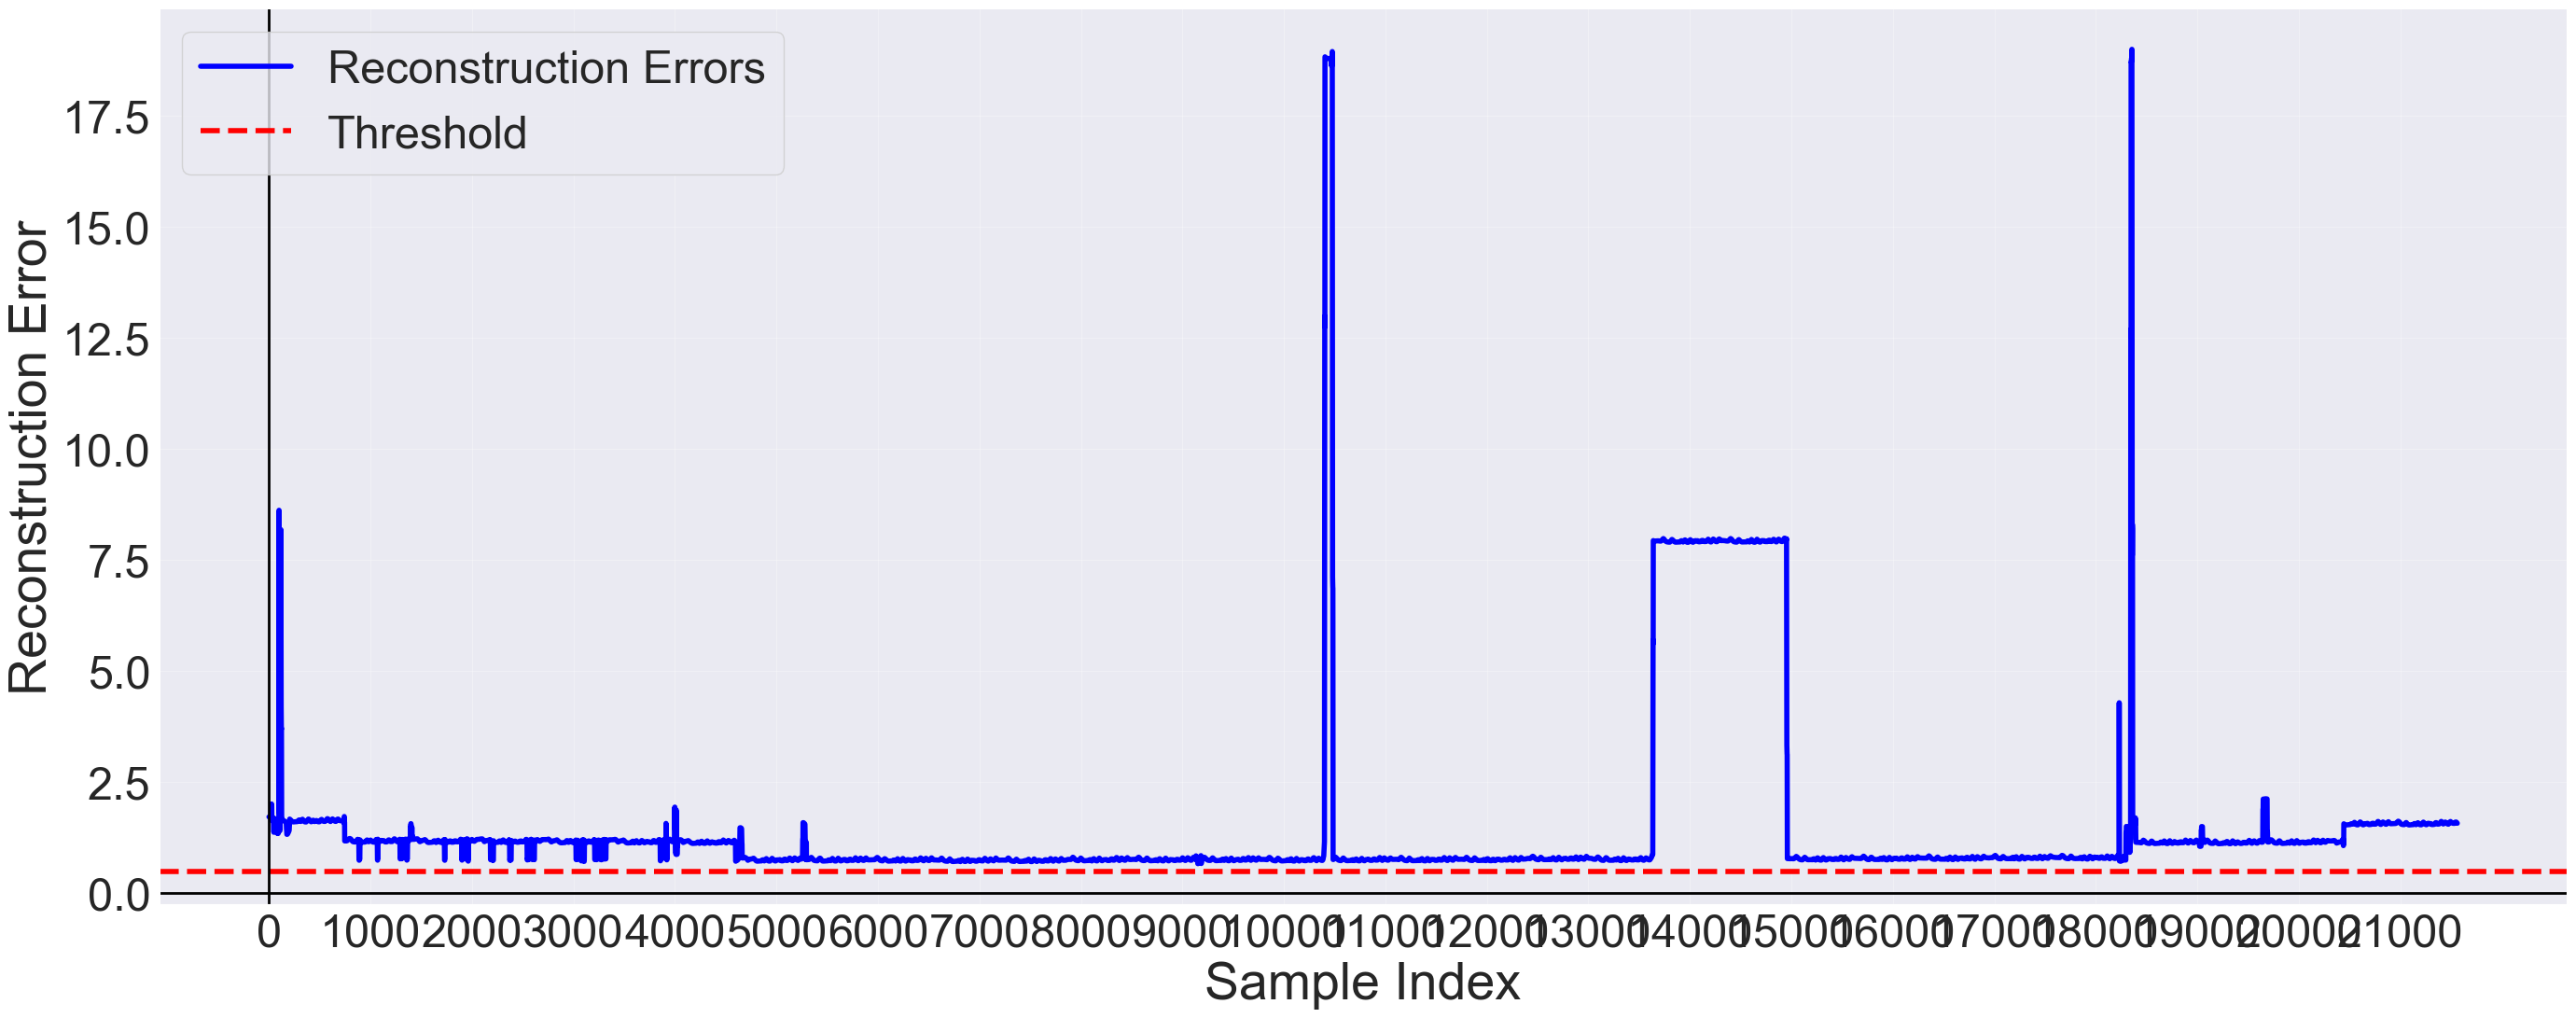

In [129]:
plot_reconstruction_errors_with_threshold(reconstruction_errors, threshold=threshold)

In [130]:
# Find the indexes where anomalies are True
indexes = np.where(anomalies == True)[0]

# Group consecutive True blocks, allowing gaps of up to 5
blocks = []
block = []

for i in range(len(indexes)):
    if not block or indexes[i] <= block[-1] + 200:
        # Start a new block or extend the current one
        block.append(indexes[i])
    else:
        # Close the current block and start a new one
        blocks.append(block)
        block = [indexes[i]]

# Append the last block
if block:
    blocks.append(block)

print(blocks)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [131]:
len(blocks)

1

In [132]:
minutes_to_exlude = 5 # around first 3 laps
# Exclude first laps
first_lap_sequences = int((minutes_to_exlude * 60 * 1000) / 240)  # (minutes_to_exlude in milliseconds / length of a row)
count = 0
for block in blocks:
    if len(block) > 1:
        if block[0] > first_lap_sequences:
            print(f"Anomaly detected from timestep {block[0]}, with len {len(block)+20}")
            count += 1
print(f"Total anomalies detected: {count}")

Total anomalies detected: 0


In [133]:
blocks[-1][0]

0

In [134]:
last_anomaly = blocks[-1][0] - 200
race_df[last_anomaly:]

,Time_in_ms,LapTime_in_ms,LapNumber,Position,Speed,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,...,Distance,TyreLife,Compound,Team,TrackStatus,Rainfall,DriverAhead,Brake,DRS,Event
21382,0.990510,0.589659,1.0,0.5,0.728972,0.285714,0.666667,1.0,0.070423,0.56196,...,0.734183,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
21383,0.990554,0.590901,1.0,0.5,0.732087,0.285714,0.666667,1.0,0.070423,0.56196,...,0.736082,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
21384,0.990566,0.591236,1.0,0.5,0.738318,0.285714,0.666667,1.0,0.070423,0.56196,...,0.736598,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
21385,0.990636,0.593206,1.0,0.5,0.750779,0.285714,0.666667,1.0,0.070423,0.56196,...,0.739668,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
21386,0.990659,0.593856,1.0,0.5,0.757009,0.285714,0.666667,1.0,0.070423,0.56196,...,0.740695,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21577,0.999880,0.853558,1.0,0.5,0.249221,0.285714,0.666667,1.0,0.070423,0.56196,...,0.979071,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
21578,0.999936,0.855134,1.0,0.5,0.249221,0.285714,0.666667,1.0,0.070423,0.56196,...,0.979887,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
21579,0.999955,0.855666,1.0,0.5,0.249221,0.285714,0.666667,1.0,0.070423,0.56196,...,0.980162,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0
21580,0.999999,0.856908,1.0,0.5,0.249221,0.285714,0.666667,1.0,0.070423,0.56196,...,0.980804,0.148148,2.0,4.0,1.0,0.0,2.0,0.0,0.0,23.0


In [135]:
#check speed variance through windows
speed = race_df['Speed']
rpm = race_df['RPM']
speed_anomaly = speed[last_anomaly:]
rpm_anomaly = rpm[last_anomaly:]

max_threshold = 80/280
min_threshold = 80/370

#create a window of 20 samples that monitors the variance of the speed
speed_mean = []
rpm_var = []
speed_entry = False
for i in range(len(speed_anomaly)-20):
    speed_mean.append(np.mean(speed_anomaly[i:i+20]))
    rpm_var.append(np.var(rpm_anomaly[i:i+20]))
    if speed_mean[-1] > min_threshold and speed_mean[-1] < max_threshold and not speed_entry \
        and rpm_var[-1] < 0.002:
        # print(speed_var[-1])
        print(f"PIT ENTRY at index {i+last_anomaly}")
        speed_entry = True

# speed_var

# plt.figure(figsize=(24, 6))
# plt.plot(speed_mean, label="Speed Variance", color='blue', linewidth=1.5)
# # plt.plot(list(speed_anomaly), label="Speed", color='red', linewidth=1.5)
# plt.xlabel("Sample Index")
# race_df[last_anomaly:]

PIT ENTRY at index -24


In [136]:
rpm_var

[0.0023759922478348017,
 0.002628443529829383,
 0.002987890038639307,
 0.0034302882850170135,
 0.003564386395737529,
 0.0035682327579706907,
 0.003580135526135564,
 0.0036386032588779926,
 0.0035852864384651184,
 0.0034759831614792347,
 0.0033923592418432236,
 0.003442181972786784,
 0.003135086502879858,
 0.0031825087498873472,
 0.0034953500144183636,
 0.004069454502314329,
 0.004961749073117971,
 0.006710174027830362,
 0.008472800254821777,
 0.010218679904937744,
 0.01229214109480381,
 0.014664098620414734,
 0.017187513411045074,
 0.01985006593167782,
 0.022352764382958412,
 0.02382514998316765,
 0.02419055625796318,
 0.021555311977863312,
 0.019779903814196587,
 0.019215872511267662,
 0.0190561693161726,
 0.017369817942380905,
 0.017281262204051018,
 0.01877475716173649,
 0.020692521706223488,
 0.022927556186914444,
 0.025527337566018105,
 0.02752540446817875,
 0.029001882299780846,
 0.02930590882897377,
 0.028404876589775085,
 0.026532072573900223,
 0.02376377023756504,
 0.020063534